In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

# Data Read

In [2]:
data = pd.read_csv("train.csv" , parse_dates=['Tarih'])
data.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [3]:
future_data = pd.read_csv("future.csv", parse_dates=['Tarih']).drop('Unnamed: 0' , axis = 1)
future_data.head()

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,NaN
1,2022-08-01 01:00:00,NaN
2,2022-08-01 02:00:00,NaN
3,2022-08-01 03:00:00,NaN
4,2022-08-01 04:00:00,NaN


In [4]:
med = pd.read_csv("med.csv" , parse_dates=['Tarih'])
med.head()

,Tarih
0,2019-12-23
1,2019-06-12
2,2019-01-25
3,2019-09-25
4,2019-03-29


# Data Splits and Feature Engineering

In [5]:
test_data = data.loc[data.Tarih > '2022-03-23 23:00:00'].copy()
train_data = data.loc[data.Tarih <= '2022-03-23 23:00:00'].copy()

In [6]:
# X_val = X_train[-96:]
# X_train = X_train[:-96]

all_data = [train_data , test_data , future_data , data]

In [7]:
from feat_engs import create_datetimes, create_businessDay_cumulativeholidays ,create_electricOutage_timeofDay , create_holiday_weekend , create_hourly_sin_cos , create_outage_rolling_percentages , create_seasons

for df in all_data :
    create_datetimes(df)
    create_holiday_weekend(df)
    create_businessDay_cumulativeholidays(df)
    create_electricOutage_timeofDay(df , med)
    create_hourly_sin_cos(df)
    create_outage_rolling_percentages(df)
    create_seasons(df)
    df.set_index('Tarih' , inplace=True)
    df.drop('date' , axis = 1 ,inplace=True)

In [8]:
train_data

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday,...,hour_cos,outage_percentage,rolling_outages_24h,exp_avg_outages_24h,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
Tarih,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,1,1,...,1.000000,0.000000,0.0,0.000000e+00,0,0,0,0,0,-1
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,1,1,...,0.965926,0.000000,0.0,0.000000e+00,0,0,0,0,0,-1
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,1,1,...,0.866025,0.000000,0.0,0.000000e+00,0,0,0,0,0,-1
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,1,1,...,0.707107,0.000000,0.0,0.000000e+00,0,0,0,0,0,-1
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,1,1,...,0.500000,0.000000,0.0,0.000000e+00,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-23 19:00:00,2367.859579,19,2,1,3,2022,82,23,12,0,...,0.258819,1.944474,0.0,1.082459e-113,1,0,0,0,0,-1
2022-03-23 20:00:00,2408.812850,20,2,1,3,2022,82,23,12,0,...,0.500000,1.944422,0.0,9.742129e-114,1,0,0,0,0,-1
2022-03-23 21:00:00,2287.339196,21,2,1,3,2022,82,23,12,0,...,0.707107,1.944369,0.0,8.767916e-114,1,0,0,0,0,-1


In [9]:
# from astral.sun import sun
# from astral import LocationInfo
# import pytz

# location_izmir = LocationInfo("Izmir", "Turkey")
# location_izmir.latitude = 38.419200
# location_izmir.longitude = 27.128700
# location_izmir.timezone = pytz.timezone("Turkey")

# location_manisa = LocationInfo("Manisa", "Turkey")
# location_manisa.latitude = 38.612000
# location_manisa.longitude = 27.426000
# location_manisa.timezone = pytz.timezone("Turkey")

# def daylight_hours_izmir(date):
#     s = sun(location_izmir.observer, date=date)
#     daylight_duration = (s['sunset'] - s['sunrise']).seconds / 3600
#     return daylight_duration

# def daylight_hours_manisa(date):
#     s = sun(location_manisa.observer, date=date)
#     daylight_duration = (s['sunset'] - s['sunrise']).seconds / 3600
#     return daylight_duration

# for dataset in all_data :
#     dataset['Daylight_hours_Izmir'] = dataset['Tarih'].apply(daylight_hours_izmir)
#     dataset['Daylight_hours_Manisa'] = dataset['Tarih'].apply(daylight_hours_manisa)
#     dataset


<Axes: >

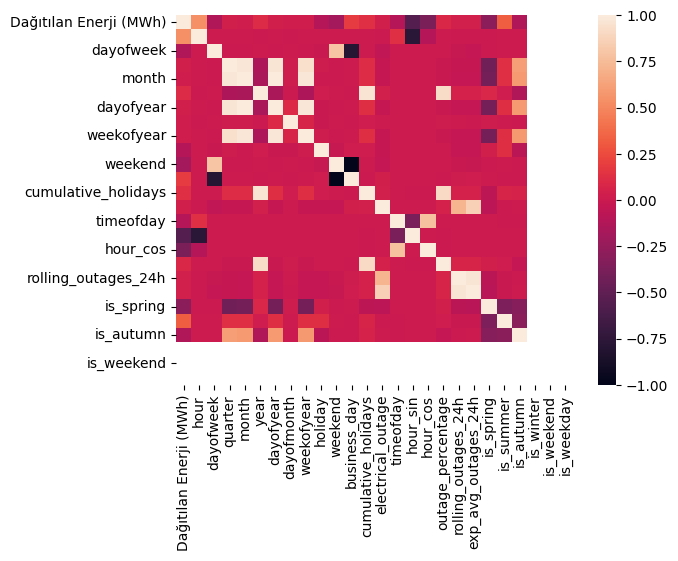

In [10]:
corr = data.corr()
sns.heatmap(corr)

In [11]:
# for df in all_data :
#     df = df.drop(['dayofyear','weekofyear','rolling_outages_24h'], axis =1)

In [12]:
data = data.drop(['dayofyear','weekofyear','rolling_outages_24h'], axis =1)
train_data = train_data.drop(['dayofyear','weekofyear','rolling_outages_24h'], axis =1)
test_data = test_data.drop(['dayofyear','weekofyear','rolling_outages_24h'], axis =1)
future_data = future_data.drop(['dayofyear','weekofyear','rolling_outages_24h'], axis =1)

In [13]:
y_train = train_data['Dağıtılan Enerji (MWh)']
X_train = train_data.copy()

y_test = test_data['Dağıtılan Enerji (MWh)']
X_test = test_data.copy()

y = data['Dağıtılan Enerji (MWh)']
X = data.copy()

In [14]:
X_train

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofmonth,holiday,weekend,business_day,...,hour_sin,hour_cos,outage_percentage,exp_avg_outages_24h,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
Tarih,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,0,1,...,0.000000,1.000000,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,0,1,...,0.258819,0.965926,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,0,1,...,0.500000,0.866025,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,0,1,...,0.707107,0.707107,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,0,1,...,0.866025,0.500000,0.000000,0.000000e+00,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-23 19:00:00,2367.859579,19,2,1,3,2022,23,0,0,1,...,-0.965926,0.258819,1.944474,1.082459e-113,1,0,0,0,0,-1
2022-03-23 20:00:00,2408.812850,20,2,1,3,2022,23,0,0,1,...,-0.866025,0.500000,1.944422,9.742129e-114,1,0,0,0,0,-1
2022-03-23 21:00:00,2287.339196,21,2,1,3,2022,23,0,0,1,...,-0.707107,0.707107,1.944369,8.767916e-114,1,0,0,0,0,-1


# Model time

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

In [16]:
'''
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

base_model = CatBoostRegressor(verbose=False, bootstrap_type='MVS')

params = {
    'iterations': np.arange(1000, 3000, 50),
    'learning_rate': np.logspace(-4, 0, 40),
    'depth': range(6, 10),
    'colsample_bylevel': np.arange(0.1, 1.1, 0.1),
    'l2_leaf_reg': np.arange(0, 10),
    }

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
random_search = RandomizedSearchCV(base_model, param_distributions=params, n_iter=40, cv=3, scoring=mape_scorer, random_state=53)
random_search.fit(X_train, y_train)

print(f"""
      En iyi CatBoost parametreleri : {random_search.best_params_}
      En iyi mape skorumuz : {-random_search.best_score_}
      """)
'''

'\nfrom catboost import CatBoostRegressor\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import make_scorer, mean_absolute_percentage_error\n\nbase_model = CatBoostRegressor(verbose=False, bootstrap_type=\'MVS\')\n\nparams = {\n    \'iterations\': np.arange(1000, 3000, 50),\n    \'learning_rate\': np.logspace(-4, 0, 40),\n    \'depth\': range(6, 10),\n    \'colsample_bylevel\': np.arange(0.1, 1.1, 0.1),\n    \'l2_leaf_reg\': np.arange(0, 10),\n    }\n\nmape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)\nrandom_search = RandomizedSearchCV(base_model, param_distributions=params, n_iter=40, cv=3, scoring=mape_scorer, random_state=53)\nrandom_search.fit(X_train, y_train)\n\nprint(f"""\n      En iyi CatBoost parametreleri : {random_search.best_params_}\n      En iyi mape skorumuz : {-random_search.best_score_}\n      """)\n'

In [17]:
model = CatBoostRegressor(iterations=2200, learning_rate=0.6352, depth=6,l2_leaf_reg=7,colsample_bylevel= 0.5352, loss_function='MAPE', bootstrap_type='MVS')
# model = CatBoostRegressor(iterations=1800, subsample=0.4, learning_rate=0.075, depth=16, l2_leaf_reg= 4,colsample_bylevel= 1, loss_function='MAPE', bootstrap_type='MVS')

In [18]:
model.fit(X_train,y_train , verbose= False)

In [19]:
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test , y_pred)

0.016259503445460403

In [ ]:
# X_train = X_train.reset_index(drop=True)
# X_train

# Final Model

In [20]:
model = CatBoostRegressor(iterations=2200, learning_rate=0.6352, depth=6,l2_leaf_reg=7,colsample_bylevel= 0.5352, loss_function='MAPE', bootstrap_type='MVS')

In [21]:
model.fit(X,y , verbose= False)

In [22]:
y_pred = model.predict(X_test) 
mean_absolute_percentage_error(y_test , y_pred)

0.009706596211625226

In [23]:
X = X.reset_index(drop=True)
X

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofmonth,holiday,weekend,business_day,...,hour_sin,hour_cos,outage_percentage,exp_avg_outages_24h,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
0,1593.944216,0,0,1,1,2018,1,1,0,1,...,0.000000,1.000000,0.000000,0.000000e+00,0,0,0,0,0,-1
1,1513.933887,1,0,1,1,2018,1,1,0,1,...,0.258819,0.965926,0.000000,0.000000e+00,0,0,0,0,0,-1
2,1402.612637,2,0,1,1,2018,1,1,0,1,...,0.500000,0.866025,0.000000,0.000000e+00,0,0,0,0,0,-1
3,1278.527266,3,0,1,1,2018,1,1,0,1,...,0.707107,0.707107,0.000000,0.000000e+00,0,0,0,0,0,-1
4,1220.697701,4,0,1,1,2018,1,1,0,1,...,0.866025,0.500000,0.000000,0.000000e+00,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40147,2492.489498,19,6,3,7,2022,31,0,1,0,...,-0.965926,0.258819,1.793365,1.866555e-256,0,1,0,0,0,-1
40148,2479.958245,20,6,3,7,2022,31,0,1,0,...,-0.866025,0.500000,1.793320,1.679900e-256,0,1,0,0,0,-1
40149,2485.016884,21,6,3,7,2022,31,0,1,0,...,-0.707107,0.707107,1.793275,1.511910e-256,0,1,0,0,0,-1
40150,2396.574255,22,6,3,7,2022,31,0,1,0,...,-0.500000,0.866025,1.793231,1.360719e-256,0,1,0,0,0,-1


# Future Predictions

In [24]:
last_window = X[-24:]
last_window

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofmonth,holiday,weekend,business_day,...,hour_sin,hour_cos,outage_percentage,exp_avg_outages_24h,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
40128,2193.865486,0,6,3,7,2022,31,0,1,0,...,0.000000e+00,1.000000e+00,1.794214,1.381762e-255,0,1,0,0,0,-1
40129,2054.943313,1,6,3,7,2022,31,0,1,0,...,2.588190e-01,9.659258e-01,1.794169,1.243585e-255,0,1,0,0,0,-1
40130,1928.728870,2,6,3,7,2022,31,0,1,0,...,5.000000e-01,8.660254e-01,1.794124,1.119227e-255,0,1,0,0,0,-1
40131,1848.355637,3,6,3,7,2022,31,0,1,0,...,7.071068e-01,7.071068e-01,1.794080,1.007304e-255,0,1,0,0,0,-1
40132,1788.783848,4,6,3,7,2022,31,0,1,0,...,8.660254e-01,5.000000e-01,1.794035,9.065738e-256,0,1,0,0,0,-1
40133,1759.561690,5,6,3,7,2022,31,0,1,0,...,9.659258e-01,2.588190e-01,1.793990,8.159164e-256,0,1,0,0,0,-1
40134,1658.934897,6,6,3,7,2022,31,0,1,0,...,1.000000e+00,6.123234e-17,1.793945,7.343248e-256,0,1,0,0,0,-1
40135,1688.072148,7,6,3,7,2022,31,0,1,0,...,9.659258e-01,-2.588190e-01,1.793901,6.608923e-256,0,1,0,0,0,-1
40136,1795.943744,8,6,3,7,2022,31,0,1,0,...,8.660254e-01,-5.000000e-01,1.793856,5.948031e-256,0,1,0,0,0,-1
40137,1940.204176,9,6,3,7,2022,31,0,1,0,...,7.071068e-01,-7.071068e-01,1.793811,5.353228e-256,0,1,0,0,0,-1


In [25]:
# Son 24 saatlik verileri alın
# last_window = data_last_seq.copy().reset_index(drop=True)

# 31 gün boyunca tahminler yapmak için bir boş tahmin dizisi oluşturun
predictions = []

for i in range(31*24):
    # print((last_window).values)
    # Tahmin edilen değerleri ölçeklendirmek için son pencereyi yeniden şekillendirin
    last_window_reshaped = np.array(last_window).reshape(24, 23)

    # Son pencereyi kullanarak bir tahmin yapın
    prediction = model.predict(last_window_reshaped)[0]

    # Tahmini tahmin listesine ekleyin
    predictions.append(prediction)

    # Tahmin edilen değeri son pencerenin sonuna ekleyin ve pencereyi 1 saat kaydırın
    last_window = pd.concat([last_window.iloc[1:], future_data.iloc[[i]]], axis=0)
    last_window.loc[last_window.index[-1] , 'Dağıtılan Enerji (MWh)' ] = prediction

# Tahminleri burada kullanabilirsiniz

In [26]:
predictions

[2251.4624556216163,
 2012.0944669980104,
 1939.2076329611134,
 1852.2433744891237,
 1797.4057998079888,
 1748.091000078845,
 1615.4082814944136,
 1607.216555403825,
 1798.301345851264,
 1938.953879759892,
 2168.570777222535,
 2267.5870014339253,
 2334.5360480399227,
 2406.4224453186735,
 2443.879932915019,
 2460.2661899946406,
 2492.155916114089,
 2510.0715985077827,
 2531.870790100338,
 2491.8876750292293,
 2501.193194813575,
 2504.2277272531487,
 2424.5397535858965,
 2195.7543903863034,
 2291.44323118578,
 2020.6652660695265,
 1954.7132674380891,
 1861.6307704935307,
 1814.960538987159,
 1750.7364537821115,
 1638.7720815734924,
 1633.8528967074149,
 1804.6696186069826,
 1946.1500547912003,
 2176.734304097125,
 2277.500054930869,
 2345.020727026381,
 2410.0998348770327,
 2433.4064154853536,
 2466.1992627882173,
 2500.0049644041233,
 2516.1977292454967,
 2526.1712200411234,
 2495.202234234175,
 2486.731590651983,
 2487.133617974114,
 2414.3944125493263,
 2189.3749702107507,
 2308.2457

In [28]:
predictions[-30:]

[2512.673362504025,
 2474.592644291686,
 2419.2613746319657,
 2436.245187478383,
 2339.3909239495893,
 2065.828087404493,
 2870.5025417798092,
 2877.4983772989026,
 2334.5631215520325,
 2275.3742874323616,
 2275.5601290140703,
 2193.4252887707,
 1733.771250071504,
 2181.928290969764,
 1887.5439001126283,
 1979.9819646973715,
 2324.262247834342,
 2252.428990403301,
 2486.4894609984503,
 2486.169050180059,
 2485.652478475904,
 2485.652478475904,
 2485.3280158856514,
 2796.272345178164,
 2484.167000783846,
 2446.77515057848,
 2442.1161270744856,
 2466.626669890699,
 2347.5307303407185,
 2079.2194639494023]

In [29]:
from eval_metrics import preds_plot,eval_metrics

In [30]:
data

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofmonth,holiday,weekend,business_day,...,hour_sin,hour_cos,outage_percentage,exp_avg_outages_24h,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
Tarih,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,0,1,...,0.000000,1.000000,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,0,1,...,0.258819,0.965926,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,0,1,...,0.500000,0.866025,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,0,1,...,0.707107,0.707107,0.000000,0.000000e+00,0,0,0,0,0,-1
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,0,1,...,0.866025,0.500000,0.000000,0.000000e+00,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,2492.489498,19,6,3,7,2022,31,0,1,0,...,-0.965926,0.258819,1.793365,1.866555e-256,0,1,0,0,0,-1
2022-07-31 20:00:00,2479.958245,20,6,3,7,2022,31,0,1,0,...,-0.866025,0.500000,1.793320,1.679900e-256,0,1,0,0,0,-1
2022-07-31 21:00:00,2485.016884,21,6,3,7,2022,31,0,1,0,...,-0.707107,0.707107,1.793275,1.511910e-256,0,1,0,0,0,-1


In [31]:
target_data = data[data.index.month == 8]


In [32]:
target_data_2018 = target_data[target_data.index.year == 2018]
target_data_2019 = target_data[target_data.index.year == 2019]
target_data_2020 = target_data[target_data.index.year == 2020]
target_data_2021 = target_data[target_data.index.year == 2021]

In [33]:
target_data = target_data[['Dağıtılan Enerji (MWh)']]


In [34]:
future_data['Dağıtılan Enerji (MWh)'] = predictions
future_data = future_data['Dağıtılan Enerji (MWh)']


In [35]:
data = data['Dağıtılan Enerji (MWh)']
data

Tarih
2018-01-01 00:00:00    1593.944216
2018-01-01 01:00:00    1513.933887
2018-01-01 02:00:00    1402.612637
2018-01-01 03:00:00    1278.527266
2018-01-01 04:00:00    1220.697701
                          ...     
2022-07-31 19:00:00    2492.489498
2022-07-31 20:00:00    2479.958245
2022-07-31 21:00:00    2485.016884
2022-07-31 22:00:00    2396.574255
2022-07-31 23:00:00    2285.252844
Name: Dağıtılan Enerji (MWh), Length: 40152, dtype: float64

In [36]:
target_data.mean()

Dağıtılan Enerji (MWh)    2209.590267
dtype: float64

In [37]:
data

Tarih
2018-01-01 00:00:00    1593.944216
2018-01-01 01:00:00    1513.933887
2018-01-01 02:00:00    1402.612637
2018-01-01 03:00:00    1278.527266
2018-01-01 04:00:00    1220.697701
                          ...     
2022-07-31 19:00:00    2492.489498
2022-07-31 20:00:00    2479.958245
2022-07-31 21:00:00    2485.016884
2022-07-31 22:00:00    2396.574255
2022-07-31 23:00:00    2285.252844
Name: Dağıtılan Enerji (MWh), Length: 40152, dtype: float64

In [38]:
future_data.values.mean()

2291.2646307458454

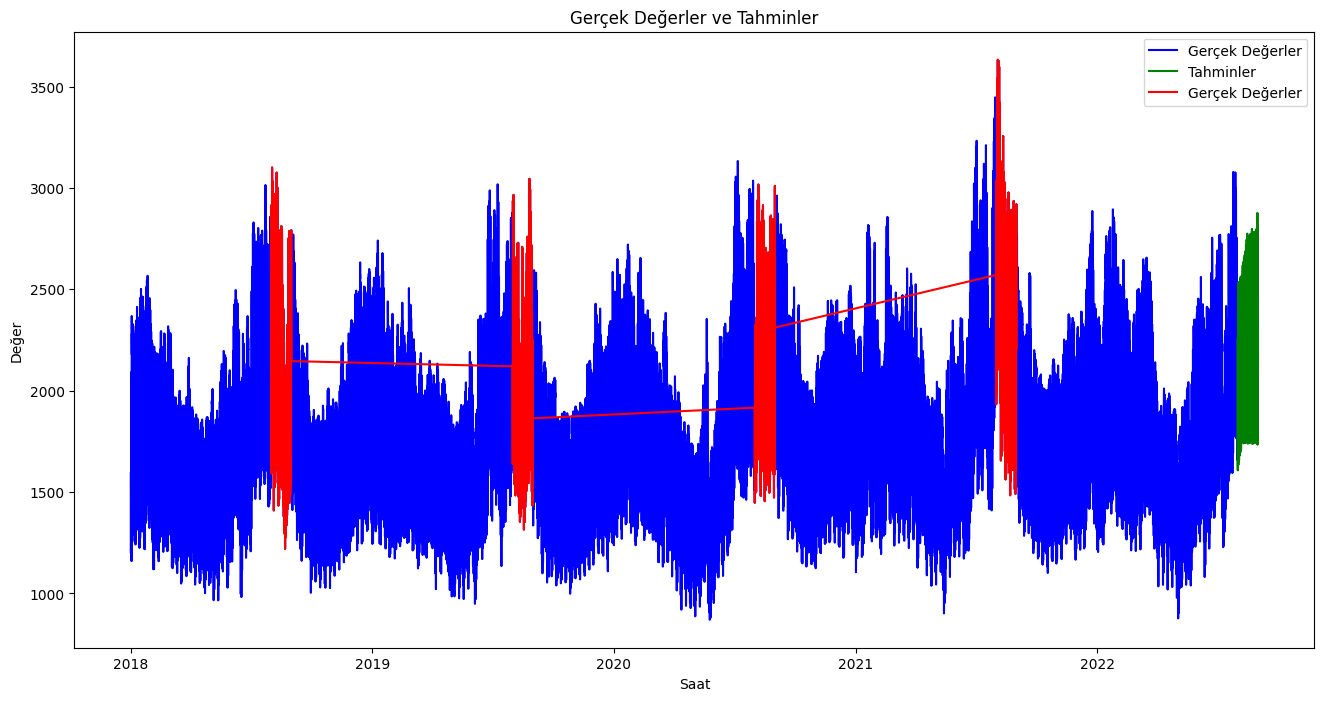

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))

preds_plot(data , future_data, target_data)

In [40]:
# future_data[(future_data.index > '2022-08-01 00:00:00') & (future_data.index < '2022-08-15 00:00:00')].values += 

sub = future_data.reset_index(drop=False)
sub

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,2251.462456
1,2022-08-01 01:00:00,2012.094467
2,2022-08-01 02:00:00,1939.207633
3,2022-08-01 03:00:00,1852.243374
4,2022-08-01 04:00:00,1797.405800
...,...,...
739,2022-08-31 19:00:00,2446.775151
740,2022-08-31 20:00:00,2442.116127
741,2022-08-31 21:00:00,2466.626670
742,2022-08-31 22:00:00,2347.530730


In [42]:
# model.save_model('catboost-.h5')
sub.to_csv('catboost-2200-lr063-dep6-leaf7-colsamp0.53-bootstrapMVS,.csv')

In [ ]:
# sub = pd.read_csv('catboost-berkant13.csv').drop('Unnamed: 0' , axis = 1)
# sub['Tarih'] = sub['Tarih'].astype('datetime64[ns]')

In [ ]:
# sub.to_csv('catboost-berkant13.csv')

In [ ]:
sub.columns

In [ ]:
future_data = pd.read_csv('future.csv').drop('Unnamed: 0' , axis  = 1)
future_data.head()

In [ ]:
future_data['Dağıtılan Enerji (MWh)'] = predictions
future_data

In [ ]:
future_data.to_csv('catboost1.csv' , index=False)

In [ ]:
# # Son pencereyi kullanarak bir tahmin yapın
# prediction = model.predict(last_window_reshaped)[0]

# # Tahmini tahmin listesine ekleyin
# predictions.append(prediction)

# # Tahmin edilen değeri future_data'nın 'Dağıtılan Enerji (MWh)' sütununa ekleyin 
# future_data.loc[i, 'Dağıtılan Enerji (MWh)'] = prediction

# # Son pencereyi güncelleyin ve ilk satırı çıkarıp, future_data'nın ilk satırını ekleyin
# last_window = last_window[1:]
# last_window.loc[len(last_window)] = future_data.loc[i]

In [ ]:
# X_future = np.arange(len(X_test), len(X_test)+744, 1).reshape(-1, 1)
# y_future = model.predict(X_future)

In [ ]:
# # Elimizdeki verilerin son 24'ü bir sonraki tahmini yapmak için kullanılacak
# last_window = data_last_seq.copy()

# # 31 gün boyunca tahminler yapmak için bir boş tahmin dizisi oluşturun
# predictions = []

# for i in range(31*24):
#     # Tahmin edilen değerleri ölçeklendirmek için son pencereyi yeniden şekillendirin
#     last_window_reshaped = last_window.reshape(1, 24, 1)

#     # Son pencereyi kullanarak bir tahmin yapın
#     prediction = model.predict(last_window_reshaped , verbose = 0)[0][0]

#     # Tahmini tahmin listesine ekleyin
#     predictions.append(prediction)

#     # Tahmin edilen değeri son pencerenin sonuna ekleyin
#     last_window = np.append(last_window[1:], prediction)
    
# # Tahminleri geri ölçeklendirin
# # predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# # Tahminlerinizi burada kullanabilirsiniz